# Referense

https://mizchi.hatenablog.com/entry/2019/02/08/183056

# Libraries

In [1]:
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Input dataset

In [2]:
train = pd.read_csv('../input/train.csv')

# Data preparation

In [3]:
def missing_value_table(df):
  #欠損値がそのカラムにいくつあるかを出力する
  null_val = df.isnull().sum()
  #それぞれのカラムで欠損値がどのくらいの割合を占めているかを計算する
  percent = 100 * df.isnull().sum()/len(df)
  #pandasのconcatメソッドで欠損数とその割合をaxis=1方向に連結する
  missing_table = pd.concat([null_val, percent], axis=1)
  #pandas.DataFrameの行名・列名を変更する
  missing_table_ren_columns = missing_table.rename(
  columns = {0 : '欠損数', 1 : '%'})
  return missing_table_ren_columns

In [4]:
missing_value_table(train)

,欠損数,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,19.865320
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna('S')

In [7]:
def data_filter(data):
    not_concerned_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
#     not_concerned_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Age']
    data = data.drop(not_concerned_columns, axis=1)
    data = data.dropna()
    return data

In [8]:
train_filter = data_filter(train)

In [9]:
train_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


In [10]:
missing_value_table(train_filter)

,欠損数,%
Survived,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


# Normalize

In [11]:
def normalize_data(data):
    # normalize Label:Sex to int
    le = LabelEncoder()
    le.fit(['male', 'female'])
    data['Sex'] = le.transform(data['Sex'])

    # normalize Pclass
    dummy_columns = ['Pclass']
    for column in dummy_columns:
        data = pd.concat([data, pd.get_dummies(
            data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)

    # normalize Fare
    ss = StandardScaler()
    data['Fare'] = ss.fit_transform(data['Fare'].values.reshape(-1, 1))

    # normalize Embarked
    dummy_columns = ['Embarked']
    for column in dummy_columns:
        data = pd.concat([data, pd.get_dummies(
            data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)

    # normalize Age
    ss = StandardScaler()
    data['Parch'] = ss.fit_transform(data['Parch'].values.reshape(-1, 1))

    # normalize Age
    ss = StandardScaler()
    data['Age'] = ss.fit_transform(data['Age'].values.reshape(-1, 1))

    return data

In [12]:
train_normalized_data = normalize_data(train_filter)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
train_normalized_data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,-0.565736,1,-0.473674,-0.502445,0,0,1,0,0,1
1,1,0,0.663861,1,-0.473674,0.786845,1,0,0,1,0,0
2,1,0,-0.258337,0,-0.473674,-0.488854,0,0,1,0,0,1
3,1,0,0.433312,1,-0.473674,0.420730,1,0,0,0,0,1
4,0,1,0.433312,0,-0.473674,-0.486337,0,0,1,0,0,1


# Split

In [14]:
def split_train_and_test(data, rate=0.8):
    data_y = data['Survived']
    data_x = data.drop(['Survived'], axis=1)

    train_valid_split_idx = int(len(data_x) * rate)
    train_x = data_x[:train_valid_split_idx]
    train_y = data_y[:train_valid_split_idx]

    valid_test_split_idx = (len(data_x) - train_valid_split_idx) // 2
    test_x = data_x[train_valid_split_idx + valid_test_split_idx:]
    test_y = data_y[train_valid_split_idx + valid_test_split_idx:]

    return train_x.values, train_y.values.reshape(-1, 1), test_x.values, test_y.values.reshape(-1, 1)

In [15]:
train_x, train_y, test_x, test_y = split_train_and_test(train_normalized_data, 0.95)

# Model

In [16]:
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim))
    model.add(Activation('relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(1, input_dim=20))
    model.add(Activation('sigmoid'))
    model.compile(optimizer=SGD(lr=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

#     # create model
#     model = Sequential()
#     model.add(Dense(64, input_dim=train_x.shape[1]))
#     for i in range(0, 8):
#         model.add(Dense(units=64))
#         model.add(Activation('relu'))
#     model.add(Dense(units=1))
#     model.add(Activation('linear'))
#     model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

    return model

In [17]:
train_x.shape[1]

11

In [18]:
model = build_model(train_x.shape[1])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot 

# SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='LR').create(prog='dot', format='svg'))

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

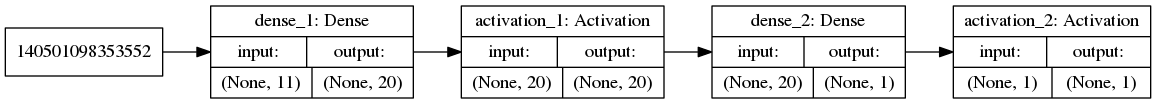

In [21]:
from IPython.display import Image, display_png
display_png(Image('model.png'))

# Train

In [22]:
history = model.fit(train_x, train_y, nb_epoch=1280, batch_size=64, verbose=1)

Instructions for updating:
Use tf.cast instead.


/home/reyes/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/1280
846/846 [==============================] - 1s 1ms/step - loss: 0.7140 - acc: 0.5768
Epoch 2/1280
846/846 [==============================] - 0s 25us/step - loss: 0.6889 - acc: 0.6359
Epoch 3/1280
846/846 [==============================] - 0s 24us/step - loss: 0.6685 - acc: 0.6560
Epoch 4/1280
846/846 [==============================] - 0s 27us/step - loss: 0.6526 - acc: 0.6667
Epoch 5/1280
846/846 [==============================] - 0s 25us/step - loss: 0.6379 - acc: 0.6726
Epoch 6/1280
846/846 [==============================] - 0s 26us/step - loss: 0.6260 - acc: 0.6773
Epoch 7/1280
846/846 [==============================] - 0s 23us/step - loss: 0.6160 - acc: 0.6773
Epoch 8/1280
846/846 [==============================] - 0s 24us/step - loss: 0.6078 - acc: 0.6868
Epoch 9/1280
846/846 [==============================] - 0s 22us/step - loss: 0.6009 - acc: 0.6974
Epoch 10/1280
846/846 [==============================] - 0s 24us/step - loss: 0.5944 - acc: 0.7033
Epoch 11/1280
846/84

846/846 [==============================] - 0s 23us/step - loss: 0.4751 - acc: 0.7979
Epoch 84/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4744 - acc: 0.7979
Epoch 85/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4738 - acc: 0.7979
Epoch 86/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4731 - acc: 0.7967
Epoch 87/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4725 - acc: 0.7967
Epoch 88/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4717 - acc: 0.7967
Epoch 89/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4712 - acc: 0.7967
Epoch 90/1280
846/846 [==============================] - 0s 26us/step - loss: 0.4705 - acc: 0.7979
Epoch 91/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4699 - acc: 0.7967
Epoch 92/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4692 - acc: 0.7967
Epoch 93/1280
846/846 [=

846/846 [==============================] - 0s 23us/step - loss: 0.4394 - acc: 0.8203
Epoch 166/1280
846/846 [==============================] - 0s 21us/step - loss: 0.4392 - acc: 0.8215
Epoch 167/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4389 - acc: 0.8215
Epoch 168/1280
846/846 [==============================] - 0s 21us/step - loss: 0.4387 - acc: 0.8215
Epoch 169/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4384 - acc: 0.8215
Epoch 170/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4382 - acc: 0.8215
Epoch 171/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4380 - acc: 0.8215
Epoch 172/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4377 - acc: 0.8215
Epoch 173/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4374 - acc: 0.8203
Epoch 174/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4373 - acc: 0.8203
Epoch 175/1280


846/846 [==============================] - 0s 22us/step - loss: 0.4250 - acc: 0.8215
Epoch 248/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4249 - acc: 0.8215
Epoch 249/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4248 - acc: 0.8191
Epoch 250/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4247 - acc: 0.8191
Epoch 251/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4246 - acc: 0.8215
Epoch 252/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4244 - acc: 0.8203
Epoch 253/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4243 - acc: 0.8203
Epoch 254/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4242 - acc: 0.8203
Epoch 255/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4240 - acc: 0.8227
Epoch 256/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4239 - acc: 0.8215
Epoch 257/1280


846/846 [==============================] - 0s 23us/step - loss: 0.4163 - acc: 0.8215
Epoch 330/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4163 - acc: 0.8215
Epoch 331/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4161 - acc: 0.8203
Epoch 332/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4160 - acc: 0.8180
Epoch 333/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4160 - acc: 0.8215
Epoch 334/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4158 - acc: 0.8203
Epoch 335/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4157 - acc: 0.8203
Epoch 336/1280
846/846 [==============================] - 0s 24us/step - loss: 0.4156 - acc: 0.8203
Epoch 337/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4155 - acc: 0.8191
Epoch 338/1280
846/846 [==============================] - 0s 21us/step - loss: 0.4153 - acc: 0.8215
Epoch 339/1280


846/846 [==============================] - 0s 23us/step - loss: 0.4110 - acc: 0.8203
Epoch 412/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4110 - acc: 0.8215
Epoch 413/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4110 - acc: 0.8203
Epoch 414/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4110 - acc: 0.8203
Epoch 415/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4110 - acc: 0.8227
Epoch 416/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4108 - acc: 0.8215
Epoch 417/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4108 - acc: 0.8227
Epoch 418/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4108 - acc: 0.8203
Epoch 419/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4108 - acc: 0.8215
Epoch 420/1280
846/846 [==============================] - 0s 24us/step - loss: 0.4107 - acc: 0.8203
Epoch 421/1280


846/846 [==============================] - 0s 22us/step - loss: 0.4074 - acc: 0.8251
Epoch 494/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4074 - acc: 0.8251
Epoch 495/1280
846/846 [==============================] - 0s 24us/step - loss: 0.4073 - acc: 0.8274
Epoch 496/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4073 - acc: 0.8262
Epoch 497/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4074 - acc: 0.8274
Epoch 498/1280
846/846 [==============================] - 0s 21us/step - loss: 0.4072 - acc: 0.8251
Epoch 499/1280
846/846 [==============================] - 0s 25us/step - loss: 0.4072 - acc: 0.8251
Epoch 500/1280
846/846 [==============================] - 0s 24us/step - loss: 0.4072 - acc: 0.8274
Epoch 501/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4071 - acc: 0.8274
Epoch 502/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4070 - acc: 0.8274
Epoch 503/1280


846/846 [==============================] - 0s 25us/step - loss: 0.4042 - acc: 0.8274
Epoch 576/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4043 - acc: 0.8274
Epoch 577/1280
846/846 [==============================] - 0s 24us/step - loss: 0.4044 - acc: 0.8251
Epoch 578/1280
846/846 [==============================] - 0s 24us/step - loss: 0.4043 - acc: 0.8251
Epoch 579/1280
846/846 [==============================] - 0s 25us/step - loss: 0.4042 - acc: 0.8262
Epoch 580/1280
846/846 [==============================] - 0s 24us/step - loss: 0.4041 - acc: 0.8262
Epoch 581/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4041 - acc: 0.8262
Epoch 582/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4040 - acc: 0.8262
Epoch 583/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4041 - acc: 0.8239
Epoch 584/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4039 - acc: 0.8262
Epoch 585/1280


846/846 [==============================] - 0s 23us/step - loss: 0.4014 - acc: 0.8274
Epoch 658/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4014 - acc: 0.8274
Epoch 659/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4014 - acc: 0.8262
Epoch 660/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4014 - acc: 0.8262
Epoch 661/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4013 - acc: 0.8262
Epoch 662/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4013 - acc: 0.8274
Epoch 663/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4012 - acc: 0.8286
Epoch 664/1280
846/846 [==============================] - 0s 22us/step - loss: 0.4012 - acc: 0.8274
Epoch 665/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4011 - acc: 0.8262
Epoch 666/1280
846/846 [==============================] - 0s 23us/step - loss: 0.4012 - acc: 0.8274
Epoch 667/1280


846/846 [==============================] - 0s 23us/step - loss: 0.3991 - acc: 0.8310
Epoch 740/1280
846/846 [==============================] - 0s 24us/step - loss: 0.3991 - acc: 0.8310
Epoch 741/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3991 - acc: 0.8310
Epoch 742/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3989 - acc: 0.8310
Epoch 743/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3989 - acc: 0.8310
Epoch 744/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3988 - acc: 0.8298
Epoch 745/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3988 - acc: 0.8298
Epoch 746/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3988 - acc: 0.8298
Epoch 747/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3989 - acc: 0.8310
Epoch 748/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3987 - acc: 0.8298
Epoch 749/1280


846/846 [==============================] - 0s 21us/step - loss: 0.3970 - acc: 0.8322
Epoch 822/1280
846/846 [==============================] - 0s 21us/step - loss: 0.3969 - acc: 0.8333
Epoch 823/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3969 - acc: 0.8333
Epoch 824/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3968 - acc: 0.8322
Epoch 825/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3968 - acc: 0.8322
Epoch 826/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3967 - acc: 0.8322
Epoch 827/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3967 - acc: 0.8322
Epoch 828/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3968 - acc: 0.8322
Epoch 829/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3967 - acc: 0.8322
Epoch 830/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3967 - acc: 0.8310
Epoch 831/1280


846/846 [==============================] - 0s 22us/step - loss: 0.3950 - acc: 0.8345
Epoch 904/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3950 - acc: 0.8333
Epoch 905/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3949 - acc: 0.8345
Epoch 906/1280
846/846 [==============================] - 0s 24us/step - loss: 0.3950 - acc: 0.8333
Epoch 907/1280
846/846 [==============================] - 0s 24us/step - loss: 0.3949 - acc: 0.8357
Epoch 908/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3950 - acc: 0.8345
Epoch 909/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3950 - acc: 0.8357
Epoch 910/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3949 - acc: 0.8357
Epoch 911/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3949 - acc: 0.8357
Epoch 912/1280
846/846 [==============================] - 0s 24us/step - loss: 0.3948 - acc: 0.8357
Epoch 913/1280


846/846 [==============================] - 0s 23us/step - loss: 0.3933 - acc: 0.8333
Epoch 986/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3932 - acc: 0.8333
Epoch 987/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3933 - acc: 0.8322
Epoch 988/1280
846/846 [==============================] - 0s 25us/step - loss: 0.3932 - acc: 0.8345
Epoch 989/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3932 - acc: 0.8333
Epoch 990/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3931 - acc: 0.8322
Epoch 991/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3932 - acc: 0.8333
Epoch 992/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3931 - acc: 0.8345
Epoch 993/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3932 - acc: 0.8333
Epoch 994/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3931 - acc: 0.8333
Epoch 995/1280


846/846 [==============================] - 0s 22us/step - loss: 0.3918 - acc: 0.8298
Epoch 1067/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3917 - acc: 0.8298
Epoch 1068/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3916 - acc: 0.8298
Epoch 1069/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3917 - acc: 0.8298
Epoch 1070/1280
846/846 [==============================] - 0s 24us/step - loss: 0.3917 - acc: 0.8298
Epoch 1071/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3916 - acc: 0.8298
Epoch 1072/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3916 - acc: 0.8298
Epoch 1073/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3915 - acc: 0.8298
Epoch 1074/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3915 - acc: 0.8286
Epoch 1075/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3914 - acc: 0.8298
Epoch 

846/846 [==============================] - 0s 22us/step - loss: 0.3899 - acc: 0.8310
Epoch 1148/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3899 - acc: 0.8310
Epoch 1149/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3899 - acc: 0.8322
Epoch 1150/1280
846/846 [==============================] - 0s 24us/step - loss: 0.3899 - acc: 0.8310
Epoch 1151/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3899 - acc: 0.8310
Epoch 1152/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3899 - acc: 0.8310
Epoch 1153/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3898 - acc: 0.8310
Epoch 1154/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3898 - acc: 0.8322
Epoch 1155/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3898 - acc: 0.8298
Epoch 1156/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3898 - acc: 0.8310
Epoch 

846/846 [==============================] - 0s 22us/step - loss: 0.3883 - acc: 0.8333
Epoch 1229/1280
846/846 [==============================] - 0s 26us/step - loss: 0.3883 - acc: 0.8333
Epoch 1230/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3883 - acc: 0.8345
Epoch 1231/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3883 - acc: 0.8322
Epoch 1232/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3884 - acc: 0.8310
Epoch 1233/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3884 - acc: 0.8298
Epoch 1234/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3883 - acc: 0.8322
Epoch 1235/1280
846/846 [==============================] - 0s 23us/step - loss: 0.3883 - acc: 0.8333
Epoch 1236/1280
846/846 [==============================] - 0s 24us/step - loss: 0.3883 - acc: 0.8333
Epoch 1237/1280
846/846 [==============================] - 0s 22us/step - loss: 0.3882 - acc: 0.8322
Epoch 

In [23]:
history.history.keys()

dict_keys(['loss', 'acc'])

0.8356973999499148
0.3871950493073069


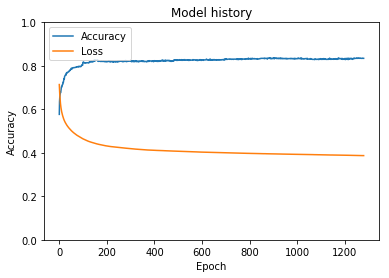

In [24]:
print(max(history.history['acc']))
print(min(history.history['loss']))

plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.ylim(0.0, 1.0)
plt.show()

# Test

In [25]:
[loss, accuracy] = model.evaluate(test_x, test_y)
print('loss:{0} -- accuracy:{1}'.format(loss, accuracy))

23/23 [==============================] - 0s 985us/step
loss:0.2214309424161911 -- accuracy:0.9130434989929199


# Prepare Test data for prediction

In [26]:
test = pd.read_csv('../input/test.csv')

In [27]:
test['Age'] = test['Age'].fillna(train['Age'].median())
test['Embarked'] = test['Embarked'].fillna('S')
test['Fare'] = test['Fare'].fillna(train['Fare'].median())

In [28]:
test_filter = data_filter(test)
missing_value_table(test_filter)

,欠損数,%
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


In [29]:
test_normalized_data = normalize_data(test_filter)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
test_normalized_data.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0.371062,0,-0.400248,-0.497413,0,0,1,0,1,0
1,0,1.358985,1,-0.400248,-0.512278,0,0,1,0,0,1
2,1,2.544493,0,-0.400248,-0.464100,0,1,0,0,1,0
3,1,-0.221692,0,-0.400248,-0.482475,0,0,1,0,0,1
4,0,-0.616861,1,0.619896,-0.417492,0,0,1,0,0,1


# Predict using keras

In [31]:
prediction_raw = model.predict(test_normalized_data)

In [32]:
prediction_raw.shape

(418, 1)

In [33]:
prediction = prediction_raw.flatten()

In [34]:
prediction.shape

(418,)

In [35]:
prediction

array([0.13165289, 0.58595645, 0.12059939, 0.11164334, 0.35416263,
       0.2440942 , 0.6699524 , 0.16588238, 0.7321473 , 0.09773982,
       0.10782677, 0.27208918, 0.98000526, 0.10903686, 0.9878934 ,
       0.9481112 , 0.11038035, 0.2856667 , 0.40133235, 0.46070677,
       0.31767243, 0.6108989 , 0.93392706, 0.65026313, 0.9199804 ,
       0.04768881, 0.93400985, 0.25745326, 0.31848752, 0.09498906,
       0.08300227, 0.10021088, 0.253295  , 0.32975766, 0.49615574,
       0.33329323, 0.55263203, 0.58179575, 0.11845738, 0.2268475 ,
       0.12428111, 0.41510645, 0.07860786, 0.89550364, 0.9846878 ,
       0.11583644, 0.32038248, 0.15486163, 0.973456  , 0.35363853,
       0.4738443 , 0.17517045, 0.9281349 , 0.9652014 , 0.16326866,
       0.04576495, 0.09110034, 0.11538404, 0.09449503, 0.9798986 ,
       0.1814805 , 0.08449641, 0.1669265 , 0.67950267, 0.2880994 ,
       0.90176046, 0.67925584, 0.28338006, 0.42608082, 0.88463557,
       0.68535095, 0.13199618, 0.545262  , 0.43964577, 0.97152

In [36]:
def bool_filter(data, th=0.5):
    data_bool = data
    data_bool[data <= th] = 0
    data_bool[data > th] = 1
    data_bool = data_bool.astype(int)
    return data_bool

In [37]:
prediction_bool = bool_filter(prediction)
prediction_bool

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Output result to file

In [38]:
# PassengerIdを取得
PassengerId = np.array(test['PassengerId']).astype(int)
# 予測データとPassengerIdをデータフレームにて結合
result = pd.DataFrame(prediction_bool, PassengerId, columns = ['Survived'])
# result.csvとして書き出し
result.to_csv('result.csv', index_label = ['PassengerId'])

# Combine

In [39]:
test['Survived'] = prediction_bool

In [40]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Survived       418 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [42]:
combine_data = train.append(test, ignore_index=True, sort=False)

In [43]:
combine_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
combine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [45]:
missing_value_table(combine_data)

,欠損数,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


# Re train

In [46]:
combine_filter = data_filter(combine_data)
combine_normalized_data = normalize_data(combine_filter)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [47]:
train_y = combine_normalized_data['Survived']
train_x = combine_normalized_data.drop(['Survived'], axis=1)

In [48]:
model = build_model(train_x.shape[1])

In [49]:
history = model.fit(train_x, train_y, nb_epoch=1280, batch_size=64, verbose=1)

/home/reyes/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/1280
1309/1309 [==============================] - 0s 111us/step - loss: 0.7063 - acc: 0.6043
Epoch 2/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.6881 - acc: 0.6150
Epoch 3/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.6721 - acc: 0.6196
Epoch 4/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.6581 - acc: 0.6241
Epoch 5/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.6453 - acc: 0.6257
Epoch 6/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.6339 - acc: 0.6287
Epoch 7/1280
1309/1309 [==============================] - 0s 25us/step - loss: 0.6234 - acc: 0.6295
Epoch 8/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.6139 - acc: 0.6364
Epoch 9/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.6049 - acc: 0.6448
Epoch 10/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.5967 - acc: 0.648

1309/1309 [==============================] - 0s 23us/step - loss: 0.3817 - acc: 0.8541
Epoch 83/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3809 - acc: 0.8533
Epoch 84/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3800 - acc: 0.8533
Epoch 85/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3793 - acc: 0.8549
Epoch 86/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3786 - acc: 0.8541
Epoch 87/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3778 - acc: 0.8526
Epoch 88/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3772 - acc: 0.8549
Epoch 89/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3765 - acc: 0.8526
Epoch 90/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3759 - acc: 0.8556
Epoch 91/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3753 - acc: 0.8549
Epoc

1309/1309 [==============================] - 0s 21us/step - loss: 0.3542 - acc: 0.8633
Epoch 163/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3539 - acc: 0.8640
Epoch 164/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3537 - acc: 0.8633
Epoch 165/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3535 - acc: 0.8625
Epoch 166/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3532 - acc: 0.8633
Epoch 167/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3530 - acc: 0.8640
Epoch 168/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3528 - acc: 0.8648
Epoch 169/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3526 - acc: 0.8633
Epoch 170/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3523 - acc: 0.8640
Epoch 171/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3520 - acc: 0.

1309/1309 [==============================] - 0s 22us/step - loss: 0.3413 - acc: 0.8739
Epoch 243/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3411 - acc: 0.8747
Epoch 244/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3411 - acc: 0.8747
Epoch 245/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3409 - acc: 0.8762
Epoch 246/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3408 - acc: 0.8747
Epoch 247/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3408 - acc: 0.8747
Epoch 248/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3407 - acc: 0.8747
Epoch 249/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3405 - acc: 0.8747
Epoch 250/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3404 - acc: 0.8762
Epoch 251/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3402 - acc: 0.

1309/1309 [==============================] - 0s 23us/step - loss: 0.3348 - acc: 0.8762
Epoch 323/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3347 - acc: 0.8762
Epoch 324/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3346 - acc: 0.8762
Epoch 325/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3345 - acc: 0.8762
Epoch 326/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3345 - acc: 0.8762
Epoch 327/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3344 - acc: 0.8762
Epoch 328/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3343 - acc: 0.8770
Epoch 329/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3342 - acc: 0.8770
Epoch 330/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3342 - acc: 0.8762
Epoch 331/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3343 - acc: 0.

1309/1309 [==============================] - 0s 21us/step - loss: 0.3305 - acc: 0.8816
Epoch 403/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3304 - acc: 0.8808
Epoch 404/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3304 - acc: 0.8808
Epoch 405/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3303 - acc: 0.8816
Epoch 406/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3303 - acc: 0.8816
Epoch 407/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3302 - acc: 0.8816
Epoch 408/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3301 - acc: 0.8808
Epoch 409/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3302 - acc: 0.8816
Epoch 410/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3301 - acc: 0.8801
Epoch 411/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3300 - acc: 0.

1309/1309 [==============================] - 0s 21us/step - loss: 0.3274 - acc: 0.8846
Epoch 483/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3273 - acc: 0.8831
Epoch 484/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3274 - acc: 0.8839
Epoch 485/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3273 - acc: 0.8839
Epoch 486/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3273 - acc: 0.8846
Epoch 487/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3272 - acc: 0.8831
Epoch 488/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3273 - acc: 0.8846
Epoch 489/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3272 - acc: 0.8839
Epoch 490/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3271 - acc: 0.8862
Epoch 491/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3272 - acc: 0.

1309/1309 [==============================] - 0s 20us/step - loss: 0.3250 - acc: 0.8869
Epoch 563/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3249 - acc: 0.8869
Epoch 564/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3249 - acc: 0.8869
Epoch 565/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3249 - acc: 0.8869
Epoch 566/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3248 - acc: 0.8877
Epoch 567/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3248 - acc: 0.8869
Epoch 568/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3248 - acc: 0.8877
Epoch 569/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3248 - acc: 0.8869
Epoch 570/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3247 - acc: 0.8877
Epoch 571/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3247 - acc: 0.

1309/1309 [==============================] - 0s 22us/step - loss: 0.3229 - acc: 0.8877
Epoch 643/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3230 - acc: 0.8862
Epoch 644/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3229 - acc: 0.8877
Epoch 645/1280
1309/1309 [==============================] - 0s 25us/step - loss: 0.3228 - acc: 0.8862
Epoch 646/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3229 - acc: 0.8869
Epoch 647/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3228 - acc: 0.8869
Epoch 648/1280
1309/1309 [==============================] - 0s 25us/step - loss: 0.3229 - acc: 0.8869
Epoch 649/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3228 - acc: 0.8885
Epoch 650/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3227 - acc: 0.8869
Epoch 651/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3227 - acc: 0.

1309/1309 [==============================] - 0s 21us/step - loss: 0.3211 - acc: 0.8900
Epoch 723/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3211 - acc: 0.8885
Epoch 724/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3211 - acc: 0.8892
Epoch 725/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3211 - acc: 0.8892
Epoch 726/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3211 - acc: 0.8885
Epoch 727/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3211 - acc: 0.8900
Epoch 728/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3210 - acc: 0.8885
Epoch 729/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3210 - acc: 0.8900
Epoch 730/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3210 - acc: 0.8892
Epoch 731/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3209 - acc: 0.

1309/1309 [==============================] - 0s 20us/step - loss: 0.3195 - acc: 0.8885
Epoch 803/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3194 - acc: 0.8900
Epoch 804/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3194 - acc: 0.8885
Epoch 805/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3194 - acc: 0.8900
Epoch 806/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3194 - acc: 0.8908
Epoch 807/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3195 - acc: 0.8892
Epoch 808/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3193 - acc: 0.8908
Epoch 809/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3194 - acc: 0.8900
Epoch 810/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3192 - acc: 0.8900
Epoch 811/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3192 - acc: 0.

1309/1309 [==============================] - 0s 22us/step - loss: 0.3180 - acc: 0.8908
Epoch 883/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3180 - acc: 0.8892
Epoch 884/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3180 - acc: 0.8908
Epoch 885/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3179 - acc: 0.8915
Epoch 886/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3180 - acc: 0.8915
Epoch 887/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3179 - acc: 0.8908
Epoch 888/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3179 - acc: 0.8908
Epoch 889/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3178 - acc: 0.8900
Epoch 890/1280
1309/1309 [==============================] - 0s 25us/step - loss: 0.3178 - acc: 0.8915
Epoch 891/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3178 - acc: 0.

1309/1309 [==============================] - 0s 21us/step - loss: 0.3166 - acc: 0.8900
Epoch 963/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3166 - acc: 0.8900
Epoch 964/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3166 - acc: 0.8908
Epoch 965/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3166 - acc: 0.8915
Epoch 966/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3165 - acc: 0.8900
Epoch 967/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3164 - acc: 0.8900
Epoch 968/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3165 - acc: 0.8908
Epoch 969/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3165 - acc: 0.8908
Epoch 970/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3165 - acc: 0.8900
Epoch 971/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3164 - acc: 0.

1309/1309 [==============================] - 0s 21us/step - loss: 0.3151 - acc: 0.8892
Epoch 1043/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3151 - acc: 0.8892
Epoch 1044/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3151 - acc: 0.8900
Epoch 1045/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3151 - acc: 0.8900
Epoch 1046/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3151 - acc: 0.8900
Epoch 1047/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3151 - acc: 0.8892
Epoch 1048/1280
1309/1309 [==============================] - 0s 24us/step - loss: 0.3150 - acc: 0.8892
Epoch 1049/1280
1309/1309 [==============================] - 0s 29us/step - loss: 0.3150 - acc: 0.8900
Epoch 1050/1280
1309/1309 [==============================] - 0s 25us/step - loss: 0.3149 - acc: 0.8885
Epoch 1051/1280
1309/1309 [==============================] - 0s 23us/step - loss: 0.3150 

1309/1309 [==============================] - 0s 21us/step - loss: 0.3140 - acc: 0.8885
Epoch 1122/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3140 - acc: 0.8892
Epoch 1123/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3140 - acc: 0.8900
Epoch 1124/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3140 - acc: 0.8885
Epoch 1125/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3139 - acc: 0.8892
Epoch 1126/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3140 - acc: 0.8885
Epoch 1127/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3140 - acc: 0.8900
Epoch 1128/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3140 - acc: 0.8892
Epoch 1129/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3139 - acc: 0.8885
Epoch 1130/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3140 

1309/1309 [==============================] - 0s 21us/step - loss: 0.3131 - acc: 0.8892
Epoch 1201/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3131 - acc: 0.8900
Epoch 1202/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3130 - acc: 0.8900
Epoch 1203/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3130 - acc: 0.8892
Epoch 1204/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3131 - acc: 0.8892
Epoch 1205/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3132 - acc: 0.8892
Epoch 1206/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3130 - acc: 0.8892
Epoch 1207/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3129 - acc: 0.8900
Epoch 1208/1280
1309/1309 [==============================] - 0s 20us/step - loss: 0.3129 - acc: 0.8892
Epoch 1209/1280
1309/1309 [==============================] - 0s 22us/step - loss: 0.3129 

1309/1309 [==============================] - 0s 21us/step - loss: 0.3117 - acc: 0.8908
Epoch 1280/1280
1309/1309 [==============================] - 0s 21us/step - loss: 0.3117 - acc: 0.8908


0.8915202450533692
0.3116834076467227


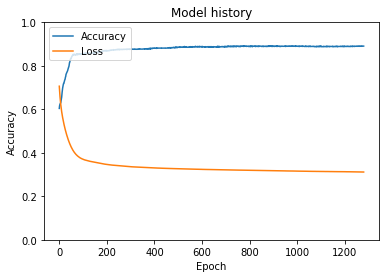

In [50]:
print(max(history.history['acc']))
print(min(history.history['loss']))

plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Model history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.ylim(0.0, 1.0)
plt.show()

In [51]:
prediction_raw = model.predict(test_normalized_data)

In [52]:
prediction = prediction_raw.flatten()

In [53]:
prediction_bool = bool_filter(prediction)

In [54]:
# PassengerIdを取得
PassengerId = np.array(test['PassengerId']).astype(int)
# 予測データとPassengerIdをデータフレームにて結合
result = pd.DataFrame(prediction_bool, PassengerId, columns = ['Survived'])
# result.csvとして書き出し
result.to_csv('result.csv', index_label = ['PassengerId'])

In [55]:
[loss, accuracy] = model.evaluate(test_x, test_y)
print('loss:{0} -- accuracy:{1}'.format(loss, accuracy))

23/23 [==============================] - 0s 1ms/step
loss:0.1895899921655655 -- accuracy:0.9130434989929199
